### **Task IV: Classical Graph Neural Network (GNN) Part**

For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.Xk1VwS2B1QI) with its corresponding description.

* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to projectthis point-cloud dataset to a set of interconnected nodes and edges.

* Discuss the resulting performance of the 2 chosen architectures.


I'm not very familiar with how Graph Neural Nets work, so I've relied heavily on the tutorials provided by the DGL package and a few GitHub implementations of GNNs


In [ ]:
!pip install dgl-cu101

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import dgl
import torch
import networkx as nx

from dgl.nn import GraphConv

In [2]:
!wget https://zenodo.org/record/3164691/files/QG_jets.npz?download=1 -O QG_jets.npz

--2021-03-23 01:28:43--  https://zenodo.org/record/3164691/files/QG_jets.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  27.7MB/s    in 4.4s    

2021-03-23 01:28:49 (23.2 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [3]:
dataset = np.load('./QG_jets.npz')

In [4]:
(x_data, y_data) = dataset['X'], dataset['y']

# Since x_data is a 3 dimensional point, the features need to be extracted

x_data = [x[0] for x in x_data]
x_data = np.array(x_data)

In [5]:
test_fraction = 0.25
size = len(y_data)
split = (int)(test_fraction * size)

(x_train, x_test) = (x_data[split:], x_data[0:split])
(y_train, y_test) = (y_data[split:], y_data[0:split])

### **Graph Implementation**

From what I was able to gather, two architectures are commonly used: Node classification and Graph classification. The former projects the data into nodes and the model is trained to classify these nodes, while the latter involves representing an entire instance as a graph, and the network is trained to classify these graphs. 

I'll first implement the Node classification architecture and then the Graph classification one. 

I have referred extensively to the tutorials provided with the DGL module as GNNs were a completely new concept to me.

#### **Node Classification**

In [6]:
x_train_red = x_train[:3000].astype(np.float32)
y_train_red = y_train[:3000]

class NodeGraphDataset(dgl.data.DGLDataset):
  def __init__(self):
    super().__init__(name='Node Architecture')
    self.num_classes = 2

  def process(self):
    self.graph = dgl.from_networkx(nx.generators.fast_gnp_random_graph(x_train_red.shape[0], 0.042, seed=42))
    self.graph.ndata['features'] = torch.from_numpy(x_train_red)
    self.graph.ndata['labels'] =  torch.from_numpy(y_train_red).long()

    n_nodes = x_train_red.shape[0]
    n_train = int(n_nodes * 0.75)
    n_val = int(n_nodes * 0.1)
    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)

    train_mask[:n_train] = True
    val_mask[n_train : n_train + n_val] = True
    test_mask[n_train + n_val:] = True
    
    self.graph.ndata['train_mask'] = train_mask
    self.graph.ndata['val_mask'] = val_mask
    self.graph.ndata['test_mask'] = test_mask

  def __getitem__(self, idx):
    return self.graph
  
  def __len__(self):
    return 0
  


In [7]:
node_classification_data = NodeGraphDataset()
node_classification_graph = node_classification_data[0]

print(node_classification_graph)

Graph(num_nodes=3000, num_edges=377162,
      ndata_schemes={'features': Scheme(shape=(4,), dtype=torch.float32), 'labels': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [8]:
class NodeClassificationModel(torch.nn.Module):
  def __init__(self, in_feats, num_classes):
    super(NodeClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, num_classes)

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.elu(h)

    h = self.conv2(g, h)
    h = torch.nn.functional.elu(h)

    h = self.conv3(g, h)

    return h

node_classification_model = NodeClassificationModel(node_classification_graph.ndata['features'].shape[1], node_classification_data.num_classes)


In [11]:
def train(g, model, num_epochs):
  """The function implementing the main train loop."""
  losses = []
  accs = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=1*1e-5, betas=(0.6, 0.7))
  best_val_acc = 0.0
  best_test_acc = 0.0

  features = g.ndata['features']
  labels = g.ndata['labels']
  train_mask = g.ndata['train_mask']
  val_mask = g.ndata['val_mask']
  test_mask = g.ndata['test_mask']

  for e in range(num_epochs):
    model.train()
    logits = model(g, features)
    preds = logits.argmax(1)

    loss = torch.nn.functional.cross_entropy(logits[train_mask], labels[train_mask])

    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    test_acc = (preds[test_mask] == labels[test_mask]).float().mean()
    losses.append(loss)
    accs['train'].append(train_acc)
    accs['val'].append(val_acc)
    accs['test'].append(test_acc)

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc
    
    with torch.no_grad():
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accs

In [12]:
node_classification_graph = node_classification_graph.to('cuda')
node_classification_model = node_classification_model.to('cuda')
node_classification_losses, node_classifications_accuracy = train(node_classification_graph, node_classification_model, 2000)

In epoch 0, loss: 3.90190053, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 5, loss: 3.88860059, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 10, loss: 3.87530684, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 15, loss: 3.86201739, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 20, loss: 3.84873271, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 25, loss: 3.83545303, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 30, loss: 3.82217669, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 35, loss: 3.80890489, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 40, loss: 3.79563665, val acc: 0.46333334 (best 0.46333334), test acc: 0.49111113 (best 0.49111113)
In epoch 45, loss: 3.

Text(0.5, 1.0, 'Loss for Node Classification')

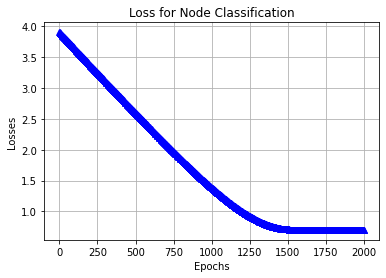

In [39]:
import matplotlib.pyplot as plt

plt.plot(node_classification_losses, 'b^-')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.title('Loss for Node Classification')

Text(0.5, 1.0, 'Accuracies for Node Classification')

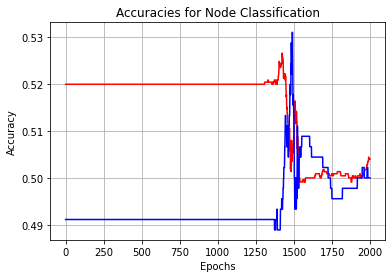

In [40]:
plt.plot(node_classifications_accuracy['train'], 'r-')
plt.plot(node_classifications_accuracy['test'], 'b-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracies for Node Classification')

#### **Graph Classification**

In [23]:
class GraphDataset(dgl.data.DGLDataset):
  def __init__(self):
    super().__init__(name="Graph Architecture") 
    self.num_classes = 2
    self.dim_nfeats = 4
  
  def process(self):
    self.graphs = []
    self.labels = []

    num_examples = len(x_train_red)
    num_train = int(num_examples * 0.75)
    num_val = int(num_examples * 0.1)

    train_mask = torch.zeros(num_examples, dtype=torch.bool)
    val_mask = torch.zeros(num_examples, dtype=torch.bool)
    test_mask = torch.zeros(num_examples, dtype=torch.bool)

    train_mask[:num_train] = True
    val_mask[num_train:num_train+num_val] = True
    test_mask[num_train+num_val:] = True
    
    self.train_mask = train_mask
    self.test_mask = test_mask
    self.val_mask = val_mask 

    for id in range(len(x_train_red)):
      g = dgl.from_networkx(nx.generators.fast_gnp_random_graph(20, p=0.6))
      g.ndata['features'] = torch.from_numpy(np.repeat(x_train_red[id].reshape(1,4),20,0))
      g.ndata['label'] = torch.LongTensor([y_train_red[id]]*20)
      self.graphs.append(g)
      self.labels.append(y_train_red[id])
    
    self.labels = torch.LongTensor(self.labels)

  def __getitem__(self, idx):
    return self.graphs[idx], self.labels[idx]

  def __len__(self):
    return len(self.graphs)

In [25]:
graph_classification_data = GraphDataset()
g_sample, label_sample = graph_classification_data[0]
print(g_sample, label_sample)

Graph(num_nodes=20, num_edges=226,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}) tensor(0)


In [30]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(graph_classification_data)
num_train = int(num_examples * 0.75)
num_val = int(num_examples * 0.1)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train+num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train+num_val, num_examples))

train_dataloader = GraphDataLoader(graph_classification_data, sampler=train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(graph_classification_data, sampler=val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(graph_classification_data, sampler=test_sampler, batch_size=5, drop_last=False)

In [31]:
it = iter(train_dataloader)
batch = next(it)
batched_graph, labels = batch
graphs = dgl.unbatch(batched_graph)

In [34]:
from dgl.nn import GraphConv

class GraphClassificationModel(torch.nn.Module):
  def __init__(self, in_feats, num_classes):
    super(GraphClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, num_classes)

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.relu(h)
    h = self.conv2(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv3(g, h)
    g.ndata['h'] = h
    return dgl.mean_nodes(g, 'h')

In [35]:
graph_classification_model = GraphClassificationModel(graph_classification_data.dim_nfeats, graph_classification_data.num_classes)

In [36]:
def train(train_loader, val_loader, test_loader, model, num_epochs):
  losses = []
  accs = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.9999))
  best_val_acc = 0.0
  best_test_acc = 0.0

  for e in range(num_epochs):
    train_acc_batch = []
    val_acc_batch = []
    test_acc_batch = []
    train_loss_batch = []
    for batched_graph, labels in train_loader:
      model.train()
      batched_graph, labels = batched_graph.to('cuda'), labels.to('cuda')
      logits = model(batched_graph, batched_graph.ndata['features'].float())
      pred = logits.argmax(1)
      loss = torch.nn.functional.cross_entropy(logits, labels)
      train_loss_batch.append(loss)
      train_acc = (pred == labels).float().mean()
      train_acc_batch.append(train_acc)
      with torch.no_grad():  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accs['train'].append(sum(train_acc_batch) / len(train_acc_batch))
    losses.append(sum(train_loss_batch) / len(train_loss_batch))

    model.eval()
    for batched_graph_val, labels_val in val_loader:
      batched_graph_val, labels_val = batched_graph_val.to('cuda'), labels_val.to('cuda')
      logits_val = model(batched_graph_val, batched_graph_val.ndata['features'].float())
      pred_val = logits_val.argmax(1)
      val_acc = (pred_val == labels_val).float().mean()
      val_acc_batch.append(val_acc)
    accs['val'].append(sum(val_acc_batch) / len(val_acc_batch))

    for batched_graph_test, labels_test in test_loader:
      batched_graph_test, labels_test = batched_graph_test.to('cuda'), labels_test.to('cuda')
      logits_test = model(batched_graph_test, batched_graph_test.ndata['features'].float())
      pred_test = logits_test.argmax(1)
      test_acc = (pred_test == labels_test).float().mean()
      test_acc_batch.append(test_acc)
    accs['test'].append(sum(test_acc_batch) / len(test_acc_batch))

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accs

In [38]:
graph_classification_model = graph_classification_model.to('cuda')
graph_classification_losses, graph_classification_accuracy = train(train_dataloader, val_dataloader, test_dataloader, graph_classification_model, 500)

In epoch 0, loss: 0.67577994, val acc: 0.40000001 (best 0.40000001), test acc: 0.40000001 (best 0.40000001)
In epoch 5, loss: 0.69448650, val acc: 0.60000002 (best 0.60000002), test acc: 0.40000001 (best 0.60000002)
In epoch 10, loss: 0.68635631, val acc: 0.40000001 (best 0.60000002), test acc: 0.40000001 (best 0.60000002)
In epoch 15, loss: 0.67699128, val acc: 0.00000000 (best 0.60000002), test acc: 0.40000001 (best 0.60000002)
In epoch 20, loss: 0.69123757, val acc: 0.80000001 (best 0.80000001), test acc: 0.80000001 (best 0.60000002)
In epoch 25, loss: 0.68830889, val acc: 0.80000001 (best 0.80000001), test acc: 0.40000001 (best 0.60000002)
In epoch 30, loss: 0.70023936, val acc: 0.40000001 (best 0.80000001), test acc: 0.40000001 (best 0.60000002)
In epoch 35, loss: 0.79623520, val acc: 0.60000002 (best 0.80000001), test acc: 0.80000001 (best 0.60000002)
In epoch 40, loss: 0.70936859, val acc: 0.80000001 (best 0.80000001), test acc: 0.40000001 (best 0.60000002)
In epoch 45, loss: 0.

Text(0.5, 1.0, 'Loss for Graph Classification')

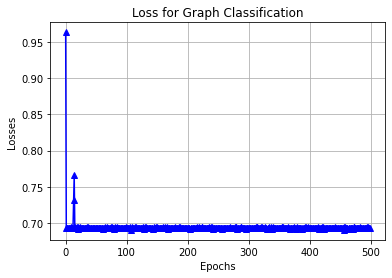

In [41]:
plt.plot(graph_classification_losses, 'b^-')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid()
plt.title('Loss for Graph Classification')

Text(0.5, 1.0, 'Accuracies for Graph Classification')

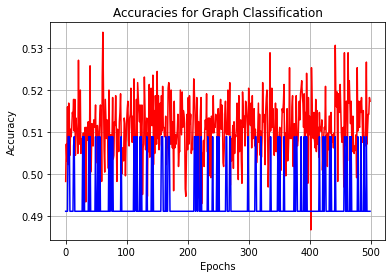

In [43]:
plt.plot(graph_classification_accuracy['train'], 'r-')
plt.plot(graph_classification_accuracy['test'], 'b-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracies for Graph Classification')

### **Inferences**

* So both architectures seem to work to some extent, with the Node Classification approach appearing to have an advantage, but the results are really not satisfactory. I attribute this to two causes:

  * One major issue was training data: the model was trained on only a small subset of the dataset which was downloaded, which in turn was only a part of the complete dataset. I had to do this as my computer could not support such resource-intensive computation and even Google Colab was having issues with the available RAM being used up completely. 

  * There were very few features in the data. Ideally quark/gluon jet production is accompanied by various scattering angles and jet momenta and energies, but here we only had 4 features to work with which might have severly impeded the performance. 

  * Finally, I think it has something to do with my implementation too. Most of it was stitched up version of various resources as GNNs are something completely new to me. I believe that there are better ways to implement the architecture, but the time constraint on tasks did not allow me to explore these architectures in detail.